# Music Genre Classification Project 
by James Potash, Rohan Poddar, Xena Maayah, Yijun Zhao, and Noame de-Boerdere

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob 
from tqdm import tqdm
import cv2
from skimage import io
import itertools 

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import inception_v3, EfficientNetB0, InceptionV3, resnet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import SGD, Adam
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import sklearn.preprocessing

In [80]:
# references: https://www.kaggle.com/code/gtessier/inceptionv3-gtzan-implementation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/AML\ Data

/content/drive/MyDrive/AML Data


In [4]:
path = "./images_original/"
genre_dict = {"blues":0, "classical":1, "country":2, "disco":3, "hiphop":4, "jazz":5, "metal":6, "pop":7, "reggae":8, "rock":9}

## Different Image Datasets

### Waveshow

In [5]:
img_folder = "Waveshow/"
df = pd.DataFrame()
g_list = []
file_list = []

for genre in genre_dict:
    for file_name in os.listdir(path + img_folder + genre):
        if file_name.endswith(".png"):
            file_list.append(file_name)
            g_list.append(genre)
    
df['filename'] = file_list
df['class'] = g_list

In [6]:
df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: class, dtype: int64

In [7]:
x = np.array(df['filename'].tolist())
x.shape

(999,)

In [8]:
y = np.array(df['class'].tolist())
y_new = pd.get_dummies(y)
print(y_new.shape)
y_new.head()

(999, 10)


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [9]:
data = df
data['path'] = df['class'] + '/' + df['filename'] 
data.head()

,filename,class,path
0,blues.00000.png,blues,blues/blues.00000.png
1,blues.00001.png,blues,blues/blues.00001.png
2,blues.00002.png,blues,blues/blues.00002.png
3,blues.00003.png,blues,blues/blues.00003.png
4,blues.00004.png,blues,blues/blues.00004.png


In [10]:
X_dev, X_test, y_dev, y_test = train_test_split(data, y_new, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)
print(str(X_train.shape) + ', ' + str(X_val.shape) + ', ' + str(X_test.shape))

(599, 3), (200, 3), (200, 3)


In [11]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
it = datagen.flow_from_dataframe(
    data,
    x_col="path",
    y_col="class", batch_size=1,
    directory=path+img_folder)

inp = Input(shape = next(it)[0][0].shape)
print(inp)

Found 999 validated image filenames belonging to 10 classes.
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [12]:
inv3_model = inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    classes=10,
    input_tensor = inp)

for layer in inv3_model.layers:
    layer.trainable=False

87910968/87910968 [==============================] - 5s 0us/step


In [13]:
new_model = Sequential()
new_model.add(inv3_model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation='softmax'))

new_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])
print(new_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 batch_normalization_94 (Bat  (None, 73728)            294912    
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)               37749248  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_95 (Bat  (None, 512)              2048      
 chNormalization)                                       

In [14]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=20, 
    min_delta = 0.001
)

history = new_model.fit(datagen.flow_from_dataframe(X_train,
                                                    x_col="path",
                                                    y_col="class",
                                                    batch_size = 32, 
                                                    directory = path + img_folder), 
                        validation_data=datagen.flow_from_dataframe(X_val,
                                                                    x_col="path",
                                                                    y_col="class",
                                                                    batch_size=32, 
                                                                    directory = path + img_folder),
                        epochs=500,                        callbacks=[es])

Found 599 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Epoch 1/500
19/19 [==============================] - 381s 19s/step - loss: 2.6932 - accuracy: 0.2137 - auc: 0.6498 - val_loss: 2.9571 - val_accuracy: 0.2900 - val_auc: 0.7181
Epoch 2/500
19/19 [==============================] - 8s 403ms/step - loss: 2.0639 - accuracy: 0.3222 - auc: 0.7774 - val_loss: 2.2525 - val_accuracy: 0.3000 - val_auc: 0.7481
Epoch 3/500
19/19 [==============================] - 6s 342ms/step - loss: 1.7489 - accuracy: 0.4073 - auc: 0.8305 - val_loss: 1.9969 - val_accuracy: 0.3700 - val_auc: 0.7645
Epoch 4/500
19/19 [==============================] - 7s 393ms/step - loss: 1.5851 - accuracy: 0.4541 - auc: 0.8587 - val_loss: 1.9078 - val_accuracy: 0.4350 - val_auc: 0.7774
Epoch 5/500
19/19 [==============================] - 7s 344ms/step - loss: 1.3868 - accuracy: 0.5175 - auc: 0.8906 - val_loss: 1.8246 - val_accuracy: 0.4050 - val_auc: 0.7920
Epo

In [15]:
test_gen = datagen.flow_from_dataframe(X_test, 
                                        x_col="path", 
                                        y_col="class", 
                                        batch_size=32, 
                                        class_mode='categorical',
                                        shuffle = False,
                                        directory = path + img_folder)

labels = pd.get_dummies(np.array(test_gen.labels))
y_pred = new_model.predict(test_gen)

y_pred_classes = np.argmax(np.array(y_pred), axis=1)
y_true = np.argmax(np.array(labels), axis=1)

m = AUC()
m.update_state(labels, y_pred)

print("Accuracy of the Test dataset:", accuracy_score(y_pred_classes, y_true))
print("AUC of the Test dataset:", m.result().numpy())

Found 200 validated image filenames belonging to 10 classes.
7/7 [==============================] - 86s 14s/step
Accuracy of the Test dataset: 0.445
AUC of the Test dataset: 0.8072722


### MFCC

In [16]:
img_folder = "MFCC/"
df = pd.DataFrame()
g_list = []
file_list = []

for genre in genre_dict:
    for file_name in os.listdir(path + img_folder + genre):
        if file_name.endswith(".png"):
            file_list.append(file_name)
            g_list.append(genre)
    
df['filename'] = file_list
df['class'] = g_list

In [17]:
df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: class, dtype: int64

In [18]:
x = np.array(df['filename'].tolist())
x.shape

(999,)

In [19]:
y = np.array(df['class'].tolist())
y_new = pd.get_dummies(y)
print(y_new.shape)
y_new.head()

(999, 10)


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [20]:
data = df
data['path'] = df['class'] + '/' + df['filename'] 
data.head()

,filename,class,path
0,blues.00000.png,blues,blues/blues.00000.png
1,blues.00001.png,blues,blues/blues.00001.png
2,blues.00002.png,blues,blues/blues.00002.png
3,blues.00003.png,blues,blues/blues.00003.png
4,blues.00004.png,blues,blues/blues.00004.png


In [21]:
X_dev, X_test, y_dev, y_test = train_test_split(data, y_new, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)
print(str(X_train.shape) + ', ' + str(X_val.shape) + ', ' + str(X_test.shape))

(599, 3), (200, 3), (200, 3)


In [22]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
it = datagen.flow_from_dataframe(
    data,
    x_col="path",
    y_col="class",batch_size=1,
    directory=path+img_folder)

inp = Input(shape = next(it)[0][0].shape)
print(inp)

Found 999 validated image filenames belonging to 10 classes.
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [23]:
inv3_model = inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    classes=10,
    input_tensor = inp)

X_test

,filename,class,path
453,hiphop.00053.png,hiphop,hiphop/hiphop.00053.png
793,pop.00094.png,pop,pop/pop.00094.png
209,country.00009.png,country,country/country.00009.png
309,disco.00009.png,disco,disco/disco.00009.png
740,pop.00041.png,pop,pop/pop.00041.png
...,...,...,...
78,blues.00078.png,blues,blues/blues.00078.png
29,blues.00029.png,blues,blues/blues.00029.png
277,country.00077.png,country,country/country.00077.png
261,country.00061.png,country,country/country.00061.png


In [24]:
for layer in inv3_model.layers:
    layer.trainable=False

In [25]:
new_model = Sequential()
new_model.add(inv3_model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation='softmax'))

new_model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy', AUC()])
print(new_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 batch_normalization_190 (Ba  (None, 73728)            294912    
 tchNormalization)                                               
                                                                 
 dense_3 (Dense)             (None, 512)               37749248  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_191 (Ba  (None, 512)              2048      
 tchNormalization)                                    

In [26]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=20, 
    min_delta = 0.001
)

history = new_model.fit(datagen.flow_from_dataframe(X_train,
                                                    x_col="path",
                                                    y_col="class",
                                                    batch_size = 32, 
                                                    directory = path + img_folder), 
                        validation_data=datagen.flow_from_dataframe(X_val,
                                                                    x_col="path",
                                                                    y_col="class",
                                                                    batch_size=32, 
                                                                    directory = path + img_folder),
                        epochs=500,
                        callbacks=[es])

Found 599 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Epoch 1/500
19/19 [==============================] - 517s 27s/step - loss: 2.4751 - accuracy: 0.2871 - auc_2: 0.7031 - val_loss: 15.3219 - val_accuracy: 0.3100 - val_auc_2: 0.6523
Epoch 2/500
19/19 [==============================] - 7s 353ms/step - loss: 1.9979 - accuracy: 0.3556 - auc_2: 0.7949 - val_loss: 6.5923 - val_accuracy: 0.2600 - val_auc_2: 0.6660
Epoch 3/500
19/19 [==============================] - 7s 383ms/step - loss: 1.8655 - accuracy: 0.4007 - auc_2: 0.8184 - val_loss: 3.4404 - val_accuracy: 0.3450 - val_auc_2: 0.7290
Epoch 4/500
19/19 [==============================] - 7s 370ms/step - loss: 1.7362 - accuracy: 0.4107 - auc_2: 0.8416 - val_loss: 2.3965 - val_accuracy: 0.3900 - val_auc_2: 0.7957
Epoch 5/500
19/19 [==============================] - 9s 456ms/step - loss: 1.5708 - accuracy: 0.4758 - auc_2: 0.8675 - val_loss: 2.1256 - val_accuracy: 0.4200 - 

In [27]:
test_gen = datagen.flow_from_dataframe(X_test, 
                                        x_col="path", 
                                        y_col="class", 
                                        batch_size=32, 
                                        class_mode='categorical',
                                        shuffle = False,
                                        directory = path + img_folder)

labels = pd.get_dummies(np.array(test_gen.labels))
y_pred = new_model.predict(test_gen)

y_pred_classes = np.argmax(np.array(y_pred), axis=1)
y_true = np.argmax(np.array(labels), axis=1)

m = AUC()
m.update_state(labels, y_pred)

print("Accuracy of the Test dataset:", accuracy_score(y_pred_classes, y_true))
print("AUC of the Test dataset:", m.result().numpy())

Found 200 validated image filenames belonging to 10 classes.
7/7 [==============================] - 111s 18s/step
Accuracy of the Test dataset: 0.415
AUC of the Test dataset: 0.80839586


### Mel Spectrogram

In [28]:
img_folder = "Mel Spectrogram/"
df = pd.DataFrame()
g_list = []
file_list = []

for genre in genre_dict:
    for file_name in os.listdir(path + img_folder + genre):
        if file_name.endswith(".png"):
            file_list.append(file_name)
            g_list.append(genre)
    
df['filename'] = file_list
df['class'] = g_list

In [29]:
df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: class, dtype: int64

In [30]:
x = np.array(df['filename'].tolist())
x.shape

(999,)

In [31]:
y = np.array(df['class'].tolist())
y_new = pd.get_dummies(y)
print(y_new.shape)
y_new.head()

(999, 10)


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [32]:
data = df
data['path'] = df['class'] + '/' + df['filename'] 
data.head()

,filename,class,path
0,blues00033.png,blues,blues/blues00033.png
1,blues00097.png,blues,blues/blues00097.png
2,blues00005.png,blues,blues/blues00005.png
3,blues00041.png,blues,blues/blues00041.png
4,blues00013.png,blues,blues/blues00013.png


In [33]:
X_dev, X_test, y_dev, y_test = train_test_split(data, y_new, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)
print(str(X_train.shape) + ', ' + str(X_val.shape) + ', ' + str(X_test.shape))

(599, 3), (200, 3), (200, 3)


In [34]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
it = datagen.flow_from_dataframe(
    data,
    x_col="path",
    y_col="class",batch_size=1,
    directory=path+img_folder)

inp = Input(shape = next(it)[0][0].shape)
print(inp)

Found 999 validated image filenames belonging to 10 classes.
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


In [35]:
inv3_model = inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    classes=10,
    input_tensor = inp)

X_test

,filename,class,path
453,hiphop00082.png,hiphop,hiphop/hiphop00082.png
793,pop00005.png,pop,pop/pop00005.png
209,country00049.png,country,country/country00049.png
309,disco00074.png,disco,disco/disco00074.png
740,pop00039.png,pop,pop/pop00039.png
...,...,...,...
78,blues00079.png,blues,blues/blues00079.png
29,blues00002.png,blues,blues/blues00002.png
277,country00060.png,country,country/country00060.png
261,country00028.png,country,country/country00028.png


In [36]:
for layer in inv3_model.layers:
    layer.trainable=False

In [37]:
new_model = Sequential()
new_model.add(inv3_model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation='softmax'))

new_model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy', AUC()])
print(new_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 batch_normalization_286 (Ba  (None, 73728)            294912    
 tchNormalization)                                               
                                                                 
 dense_6 (Dense)             (None, 512)               37749248  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_287 (Ba  (None, 512)              2048      
 tchNormalization)                                    

In [38]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=20, 
    min_delta = 0.001
)

history = new_model.fit(datagen.flow_from_dataframe(X_train,
                                                    x_col="path",
                                                    y_col="class",
                                                    batch_size = 32, 
                                                    directory = path + img_folder), 
                        validation_data=datagen.flow_from_dataframe(X_val,
                                                                    x_col="path",
                                                                    y_col="class",
                                                                    batch_size=32, 
                                                                    directory = path + img_folder),
                        epochs=500,
                        callbacks=[es])

Found 599 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Epoch 1/500
19/19 [==============================] - 532s 28s/step - loss: 2.6419 - accuracy: 0.1886 - auc_4: 0.6602 - val_loss: 15.8803 - val_accuracy: 0.3250 - val_auc_4: 0.6508
Epoch 2/500
19/19 [==============================] - 5s 253ms/step - loss: 2.1354 - accuracy: 0.3389 - auc_4: 0.7634 - val_loss: 4.0905 - val_accuracy: 0.3700 - val_auc_4: 0.7361
Epoch 3/500
19/19 [==============================] - 8s 416ms/step - loss: 1.7761 - accuracy: 0.3907 - auc_4: 0.8307 - val_loss: 3.4364 - val_accuracy: 0.3950 - val_auc_4: 0.7326
Epoch 4/500
19/19 [==============================] - 5s 241ms/step - loss: 1.7943 - accuracy: 0.4124 - auc_4: 0.8283 - val_loss: 3.2838 - val_accuracy: 0.3400 - val_auc_4: 0.7410
Epoch 5/500
19/19 [==============================] - 6s 313ms/step - loss: 1.5459 - accuracy: 0.4741 - auc_4: 0.8684 - val_loss: 2.5596 - val_accuracy: 0.3800 - 

In [39]:
test_gen = datagen.flow_from_dataframe(X_test, 
                                        x_col="path", 
                                        y_col="class", 
                                        batch_size=32, 
                                        class_mode='categorical',
                                        shuffle = False,
                                        directory = path + img_folder)

labels = pd.get_dummies(np.array(test_gen.labels))
y_pred = new_model.predict(test_gen)

y_pred_classes = np.argmax(np.array(y_pred), axis=1)
y_true = np.argmax(np.array(labels), axis=1)

m = AUC()
m.update_state(labels, y_pred)

print("Accuracy of the Test dataset:", accuracy_score(y_pred_classes, y_true))
print("AUC of the Test dataset:", m.result().numpy())

Found 200 validated image filenames belonging to 10 classes.
7/7 [==============================] - 114s 19s/step
Accuracy of the Test dataset: 0.62
AUC of the Test dataset: 0.87255275


## Different Models on Optimal Image Dataset

In [40]:
img_folder = "Mel Spectrogram/"
df = pd.DataFrame()
g_list = []
file_list = []

for genre in genre_dict:
    for file_name in os.listdir(path + img_folder + genre):
        if file_name.endswith(".png"):
            file_list.append(file_name)
            g_list.append(genre)
    
df['filename'] = file_list
df['class'] = g_list

In [41]:
x = df
x['path'] = df['class'] + '/' + df['filename'] 

y = np.array(df['class'].tolist())
y_new = pd.get_dummies(y)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data, y_new, test_size=0.2, random_state=42)
print(str(X_train.shape) + ', ' + str(X_test.shape))

(799, 3), (200, 3)


In [43]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
it = datagen.flow_from_dataframe(
    data,
    x_col="path",
    y_col="class",batch_size=1,
    directory=path+img_folder)

inp = Input(shape = next(it)[0][0].shape)
print(inp)

Found 999 validated image filenames belonging to 10 classes.
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [44]:
test_dat = ImageDataGenerator(rescale=1.0/255.0)
test_gen = datagen.flow_from_dataframe(x, 
                                        x_col="path", 
                                        y_col="class", 
                                        batch_size=32, 
                                        class_mode='categorical',
                                        shuffle = False,
                                        directory = path + img_folder)

Found 999 validated image filenames belonging to 10 classes.


### Inception V3

In [45]:
inv3_model = inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    classes=10,
    input_tensor = inp)

for layer in inv3_model.layers:
    layer.trainable=False

In [46]:
new_model = Sequential()
new_model.add(inv3_model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation='softmax'))

new_model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy', AUC()])
print(new_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 73728)             0         
                                                                 
 batch_normalization_382 (Ba  (None, 73728)            294912    
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 512)               37749248  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_383 (Ba  (None, 512)              2048      
 tchNormalization)                                    

In [47]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=20, 
    min_delta = 0.001
)

history = new_model.fit(datagen.flow_from_dataframe(X_train,
                                                    x_col="path",
                                                    y_col="class",
                                                    batch_size = 32, 
                                                    directory = path + img_folder), 
                        validation_data=datagen.flow_from_dataframe(X_test,
                                                                    x_col="path",
                                                                    y_col="class",
                                                                    batch_size=32, 
                                                                    directory = path + img_folder),
                        epochs=500,
                        callbacks=[es])

Found 799 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Epoch 1/500
25/25 [==============================] - 16s 422ms/step - loss: 2.2493 - accuracy: 0.2979 - auc_6: 0.7467 - val_loss: 2.3767 - val_accuracy: 0.3450 - val_auc_6: 0.7944
Epoch 2/500
25/25 [==============================] - 6s 238ms/step - loss: 1.4580 - accuracy: 0.5081 - auc_6: 0.8841 - val_loss: 1.5354 - val_accuracy: 0.4850 - val_auc_6: 0.8701
Epoch 3/500
25/25 [==============================] - 7s 270ms/step - loss: 1.1447 - accuracy: 0.6058 - auc_6: 0.9235 - val_loss: 1.3138 - val_accuracy: 0.5400 - val_auc_6: 0.9002
Epoch 4/500
25/25 [==============================] - 6s 237ms/step - loss: 0.8865 - accuracy: 0.7146 - auc_6: 0.9532 - val_loss: 1.2835 - val_accuracy: 0.5500 - val_auc_6: 0.9045
Epoch 5/500
25/25 [==============================] - 10s 409ms/step - loss: 0.6811 - accuracy: 0.7635 - auc_6: 0.9744 - val_loss: 1.2575 - val_accuracy: 0.5700 -

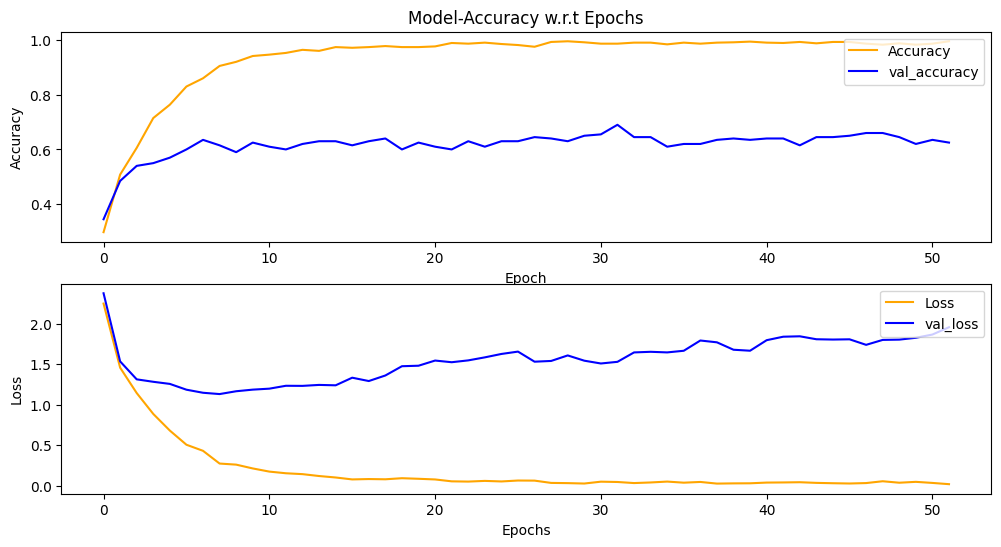

In [52]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
plt.show()

In [53]:
labels = pd.get_dummies(np.array(test_gen.labels))
y_pred = new_model.predict(test_gen)
y_pred_classes = np.argmax(np.array(y_pred), axis=1)
y_true = np.argmax(np.array(labels), axis=1)
m = AUC()
m.update_state(labels, y_pred)

print("Accuracy of the Test dataset:", accuracy_score(y_pred_classes, y_true))
print("AUC of the Test dataset:", m.result().numpy())

32/32 [==============================] - 8s 206ms/step
Accuracy of the Test dataset: 0.9369369369369369
AUC of the Test dataset: 0.98690647


<Figure size 640x480 with 0 Axes>

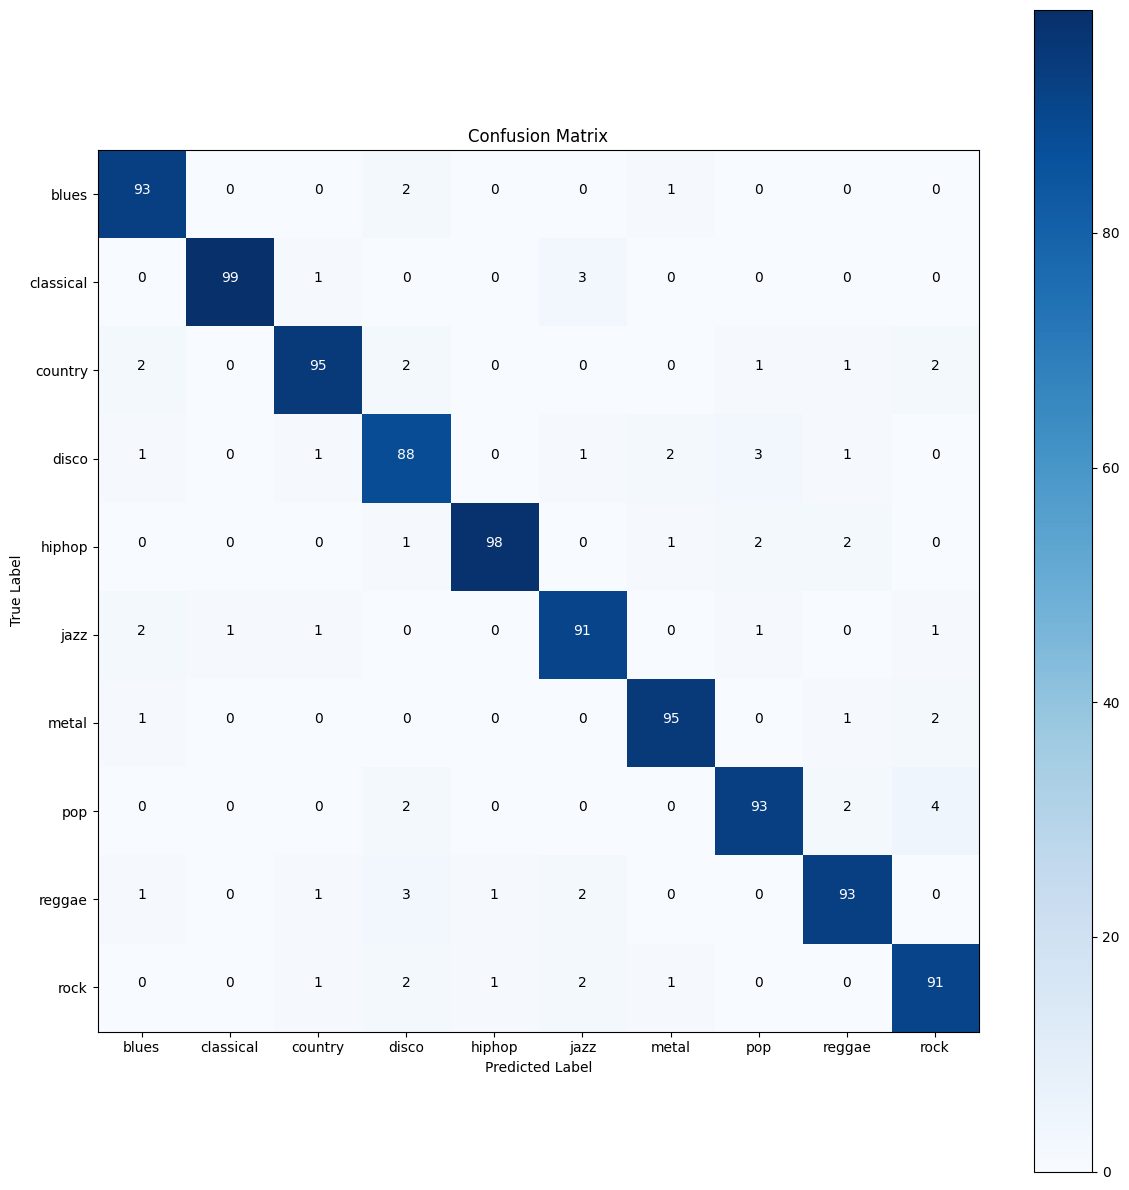

In [61]:
cm = confusion_matrix(y_pred_classes, y_true,)
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(10)))
plt.xticks(tick_marks, y_new.columns)
plt.yticks(tick_marks, y_new.columns)
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### VGG16

In [62]:
vgg_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    classes=10,
    input_tensor = inp)

for layer in vgg_model.layers:
    layer.trainable=False

58889256/58889256 [==============================] - 3s 0us/step


In [63]:
new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation='softmax'))

new_model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy', AUC()])
print(new_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_384 (Ba  (None, 32768)            131072    
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_385 (Ba  (None, 512)              2048      
 tchNormalization)                                    

In [64]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=20, 
    min_delta = 0.001
)

history = new_model.fit(datagen.flow_from_dataframe(X_train,
                                                    x_col="path",
                                                    y_col="class",
                                                    batch_size = 32, 
                                                    directory = path + img_folder), 
                        validation_data=datagen.flow_from_dataframe(X_test,
                                                                    x_col="path",
                                                                    y_col="class",
                                                                    batch_size=32, 
                                                                    directory = path + img_folder),
                        epochs=500,
                        callbacks=[es])

Found 799 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Epoch 1/500
25/25 [==============================] - 24s 641ms/step - loss: 2.0496 - accuracy: 0.3692 - auc_8: 0.7849 - val_loss: 2.6760 - val_accuracy: 0.1750 - val_auc_8: 0.7293
Epoch 2/500
25/25 [==============================] - 7s 297ms/step - loss: 1.3444 - accuracy: 0.5519 - auc_8: 0.8988 - val_loss: 2.0773 - val_accuracy: 0.1900 - val_auc_8: 0.7584
Epoch 3/500
25/25 [==============================] - 7s 286ms/step - loss: 1.0567 - accuracy: 0.6433 - auc_8: 0.9358 - val_loss: 1.6729 - val_accuracy: 0.3550 - val_auc_8: 0.8393
Epoch 4/500
25/25 [==============================] - 6s 244ms/step - loss: 0.8116 - accuracy: 0.7222 - auc_8: 0.9619 - val_loss: 1.6415 - val_accuracy: 0.4050 - val_auc_8: 0.8503
Epoch 5/500
25/25 [==============================] - 7s 277ms/step - loss: 0.6204 - accuracy: 0.7772 - auc_8: 0.9774 - val_loss: 1.4355 - val_accuracy: 0.5700 - 

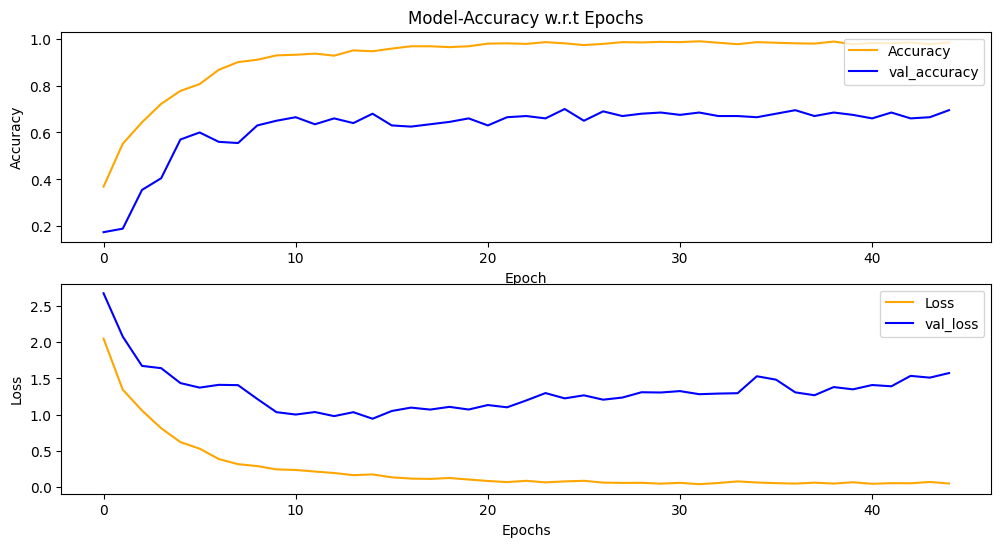

In [65]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
plt.show()

In [66]:
labels = pd.get_dummies(np.array(test_gen.labels))
y_pred = new_model.predict(test_gen)
y_pred_classes = np.argmax(np.array(y_pred), axis=1)
y_true = np.argmax(np.array(labels), axis=1)
m = AUC()
m.update_state(labels, y_pred)

print("Accuracy of the Test dataset:", accuracy_score(y_pred_classes, y_true))
print("AUC of the Test dataset:", m.result().numpy())

32/32 [==============================] - 9s 263ms/step
Accuracy of the Test dataset: 0.938938938938939
AUC of the Test dataset: 0.9917528


<Figure size 640x480 with 0 Axes>

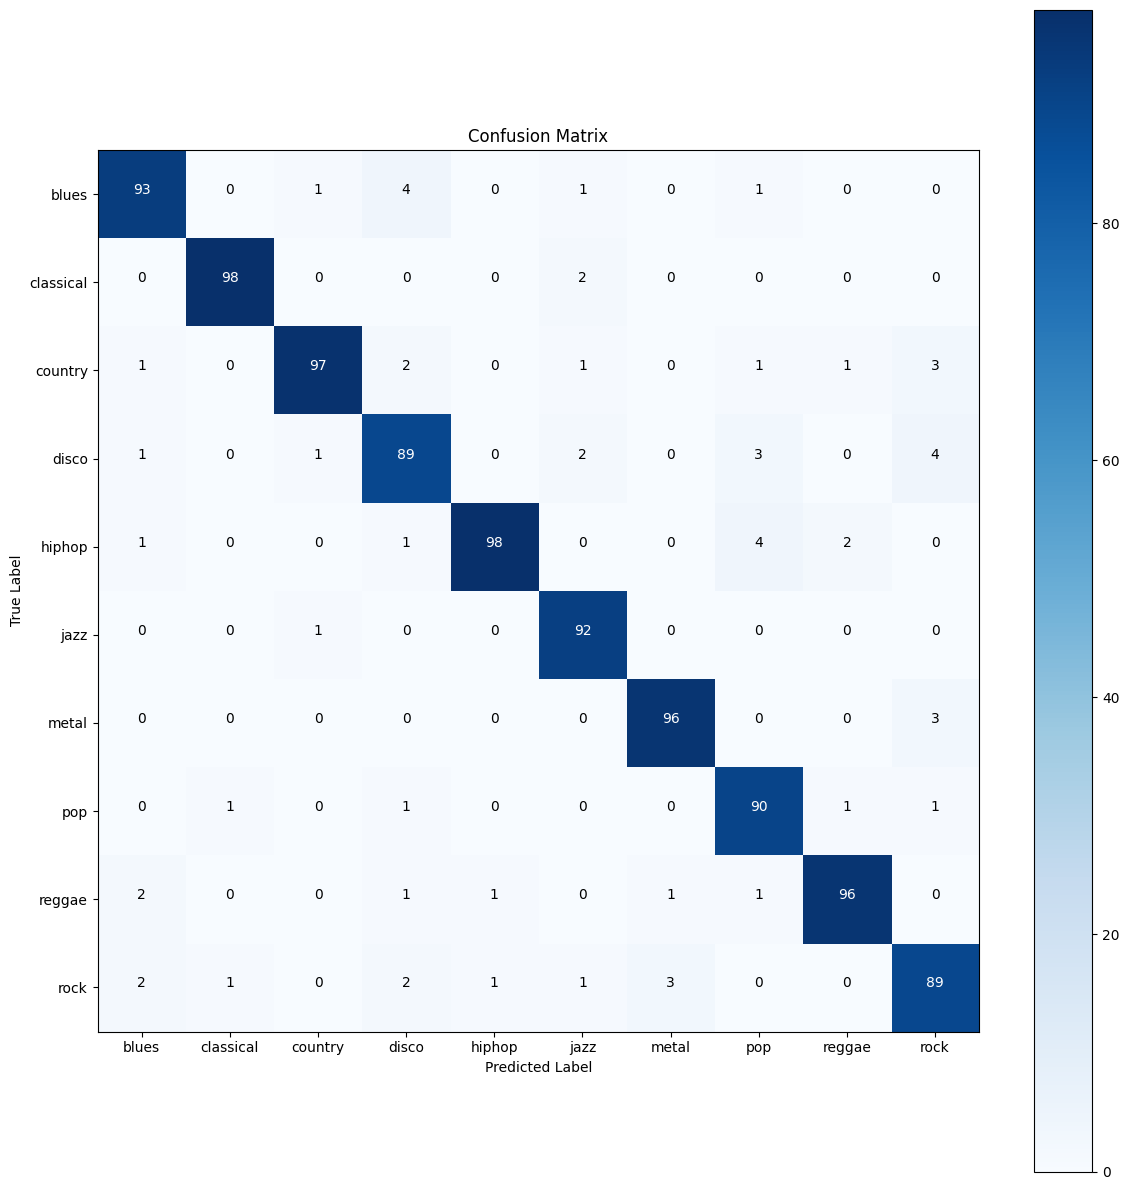

In [67]:
cm = confusion_matrix(y_pred_classes, y_true,)
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(10)))
plt.xticks(tick_marks, y_new.columns)
plt.yticks(tick_marks, y_new.columns)
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### ResNet50

In [68]:
resnet_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    classes=10,
    input_tensor=inp)

for layer in resnet_model.layers:
    layer.trainable=False

94765736/94765736 [==============================] - 5s 0us/step


In [70]:
new_model = Sequential()
new_model.add(resnet_model)
new_model.add(Flatten())
new_model.add(BatchNormalization())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(BatchNormalization())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation='softmax'))

new_model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy', AUC()])
print(new_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 batch_normalization_386 (Ba  (None, 131072)           524288    
 tchNormalization)                                               
                                                                 
 dense_15 (Dense)            (None, 512)               67109376  
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_387 (Ba  (None, 512)              2048      
 tchNormalization)                                    

In [71]:
es = EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True, 
    patience=20, 
    min_delta = 0.001
)

history = new_model.fit(datagen.flow_from_dataframe(X_train,
                                                    x_col="path",
                                                    y_col="class",
                                                    batch_size = 32, 
                                                    directory = path + img_folder), 
                        validation_data=datagen.flow_from_dataframe(X_test,
                                                                    x_col="path",
                                                                    y_col="class",
                                                                    batch_size=32, 
                                                                    directory = path + img_folder),
                        epochs=500,
                        callbacks=[es])

Found 799 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Epoch 1/500
25/25 [==============================] - 18s 426ms/step - loss: 2.5756 - accuracy: 0.2578 - auc_10: 0.6705 - val_loss: 8.1829 - val_accuracy: 0.1200 - val_auc_10: 0.5548
Epoch 2/500
25/25 [==============================] - 7s 293ms/step - loss: 2.0908 - accuracy: 0.3517 - auc_10: 0.7732 - val_loss: 4.6390 - val_accuracy: 0.1250 - val_auc_10: 0.5880
Epoch 3/500
25/25 [==============================] - 7s 260ms/step - loss: 1.9284 - accuracy: 0.3892 - auc_10: 0.8034 - val_loss: 2.9952 - val_accuracy: 0.1800 - val_auc_10: 0.6275
Epoch 4/500
25/25 [==============================] - 6s 239ms/step - loss: 1.7553 - accuracy: 0.4168 - auc_10: 0.8314 - val_loss: 2.7472 - val_accuracy: 0.1550 - val_auc_10: 0.6513
Epoch 5/500
25/25 [==============================] - 9s 378ms/step - loss: 1.5748 - accuracy: 0.4606 - auc_10: 0.8600 - val_loss: 2.3744 - val_accuracy: 

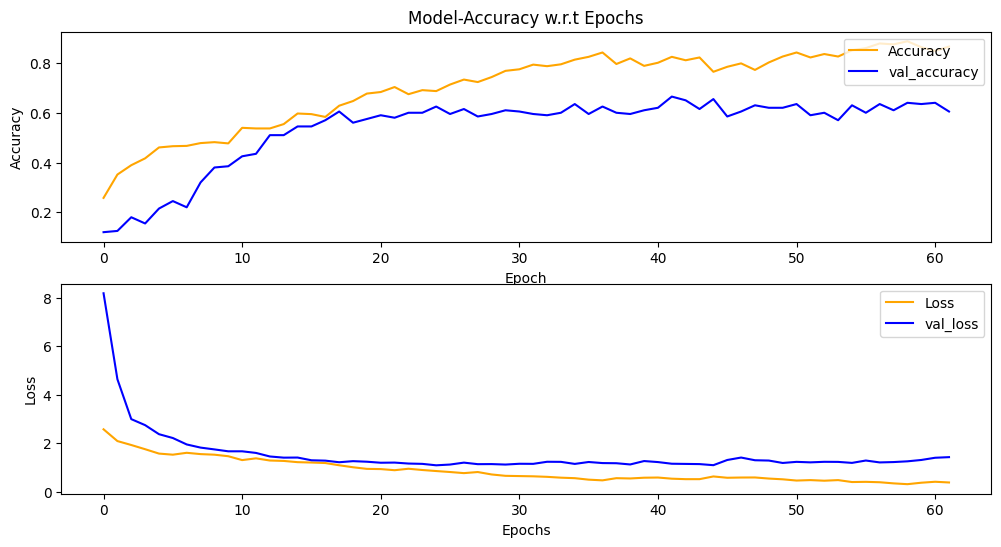

In [72]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
plt.show()

In [73]:
labels = pd.get_dummies(np.array(test_gen.labels))
y_pred = new_model.predict(test_gen)
y_pred_classes = np.argmax(np.array(y_pred), axis=1)
y_true = np.argmax(np.array(labels), axis=1)
m = AUC()
m.update_state(labels, y_pred)

print("Accuracy of the Test dataset:", accuracy_score(y_pred_classes, y_true))
print("AUC of the Test dataset:", m.result().numpy())

32/32 [==============================] - 8s 216ms/step
Accuracy of the Test dataset: 0.9049049049049049
AUC of the Test dataset: 0.98901755


<Figure size 640x480 with 0 Axes>

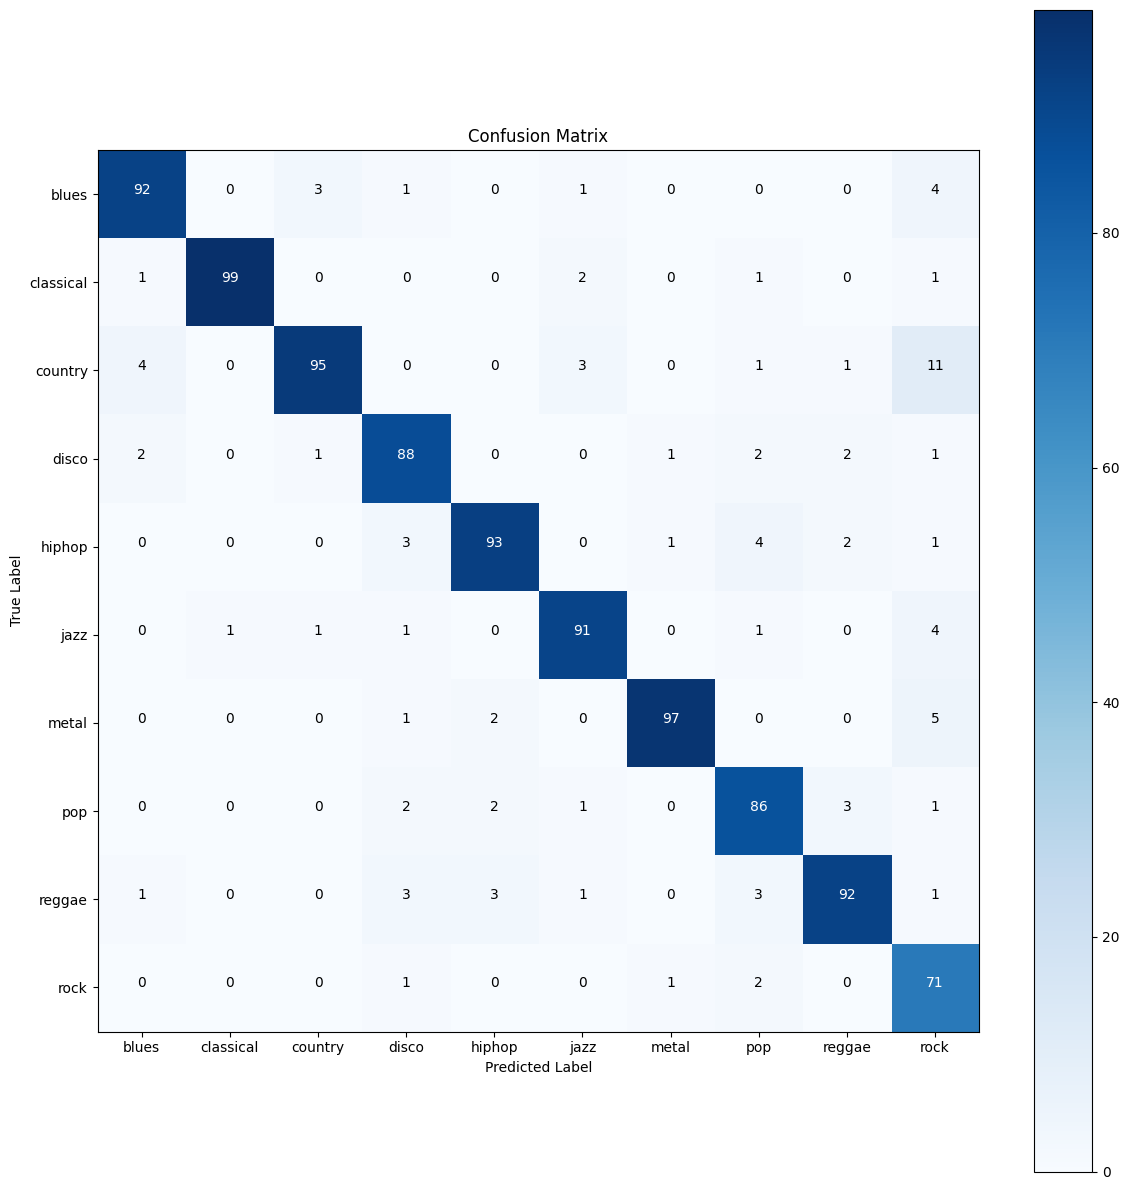

In [74]:
cm = confusion_matrix(y_pred_classes, y_true,)
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(10)))
plt.xticks(tick_marks, y_new.columns)
plt.yticks(tick_marks, y_new.columns)
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()